<a href="https://colab.research.google.com/github/mak109/cs6910_assignment2/blob/main/cs6910_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget
!pip install -U albumentations

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=81af78ceaa4896f4512acd508a5d440b104b2c895a8324c75c9260ac28727826
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 102 kB 4.7 MB/s 
     |████████████████████████████████| 47.8 MB 66 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import wget
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models,utils
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import cv2

import glob
from tqdm import tqdm
from zipfile import ZipFile
plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
url='https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
filename = os.path.basename(url)

if not os.path.exists(filename):
  filename = wget.download(url)
  with ZipFile(filename, 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')
  os.remove(filename)

Extracting all the files now...
Done!


In [ ]:
params = {
#    "model": "resnet50",
    #"device": "cuda",
#    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 2,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 10
}

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(size=(params['image_size'],params['image_size'])),
        transforms.ToTensor(),
        # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        
    ])

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=(params['image_size'],params['image_size'])),
        transforms.ToTensor(),
        # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        
      
    ]
)

In [ ]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'inaturalist_12K/train' 
test_data_path = 'inaturalist_12K/val'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))   
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

print(len(train_image_paths))
#split train valid from train paths (90,10)
train_image_paths, valid_image_paths = train_image_paths[:int(0.9*len(train_image_paths))], train_image_paths[int(0.9*len(train_image_paths)):] 


test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("\nTrain size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  inaturalist_12K/train/Insecta/737313cd068756f3fe0f944ad4e5fee1.jpg
class example:  Animalia
9999

Train size: 8999
Valid size: 1000
Test size: 2000


In [ ]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
print('Length of train: ', len(train_image_paths))
print('Length of test: ', len(test_image_paths))

Length of train:  8999
Length of test:  2000


In [ ]:
#######################################################
#               Define Dataset Class
#######################################################
from PIL import Image
class INaturalistDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath).convert('RGB')
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [ ]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = INaturalistDataset(train_image_paths,train_transforms)
valid_dataset = INaturalistDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = INaturalistDataset(test_image_paths,test_transforms)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=params["batch_size"],
                                          shuffle=True, num_workers=params["num_workers"])
validationloader = torch.utils.data.DataLoader(valid_dataset, batch_size=params["batch_size"],
                                          shuffle=True, num_workers=params["num_workers"])
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=params["batch_size"],
                                          shuffle=False, num_workers=params["num_workers"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


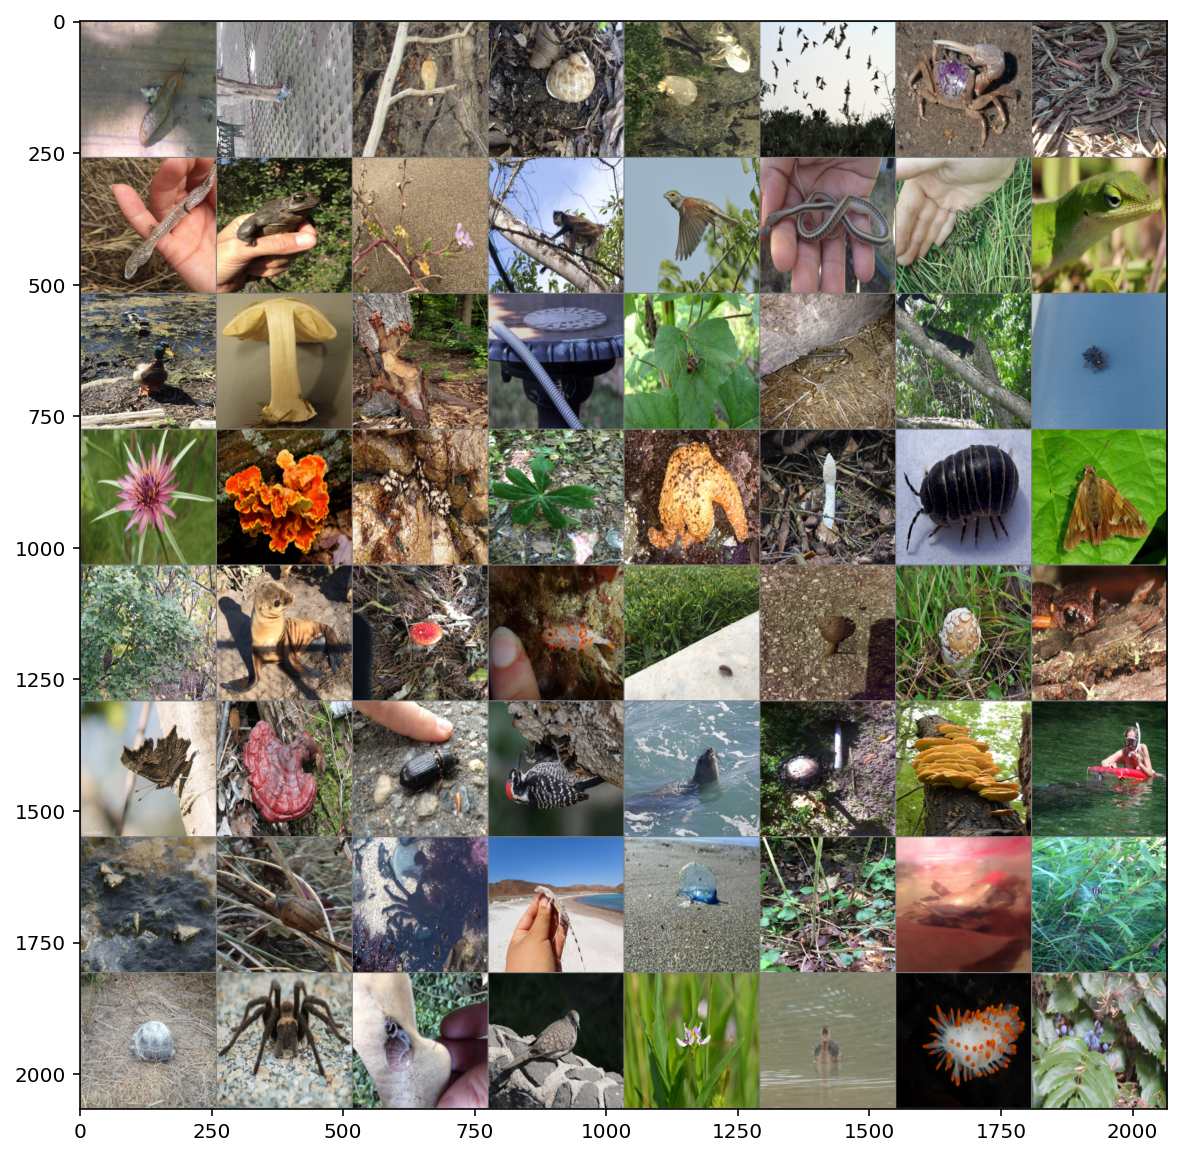

Mollusca Aves  Aves  Mollusca Mollusca Mammalia Animalia Reptilia Reptilia Amphibia Plantae Mammalia Aves  Reptilia Amphibia Reptilia Aves  Fungi Mammalia Arachnida Arachnida Amphibia Mammalia Arachnida Plantae Fungi Animalia Plantae Animalia Fungi Animalia Insecta Aves  Mammalia Fungi Mollusca Animalia Mollusca Fungi Amphibia Insecta Fungi Insecta Aves  Mammalia Fungi Fungi Mammalia Mollusca Mollusca Animalia Reptilia Animalia Plantae Amphibia Arachnida Reptilia Arachnida Mollusca Aves  Plantae Aves  Mollusca Plantae


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(params["batch_size"])))

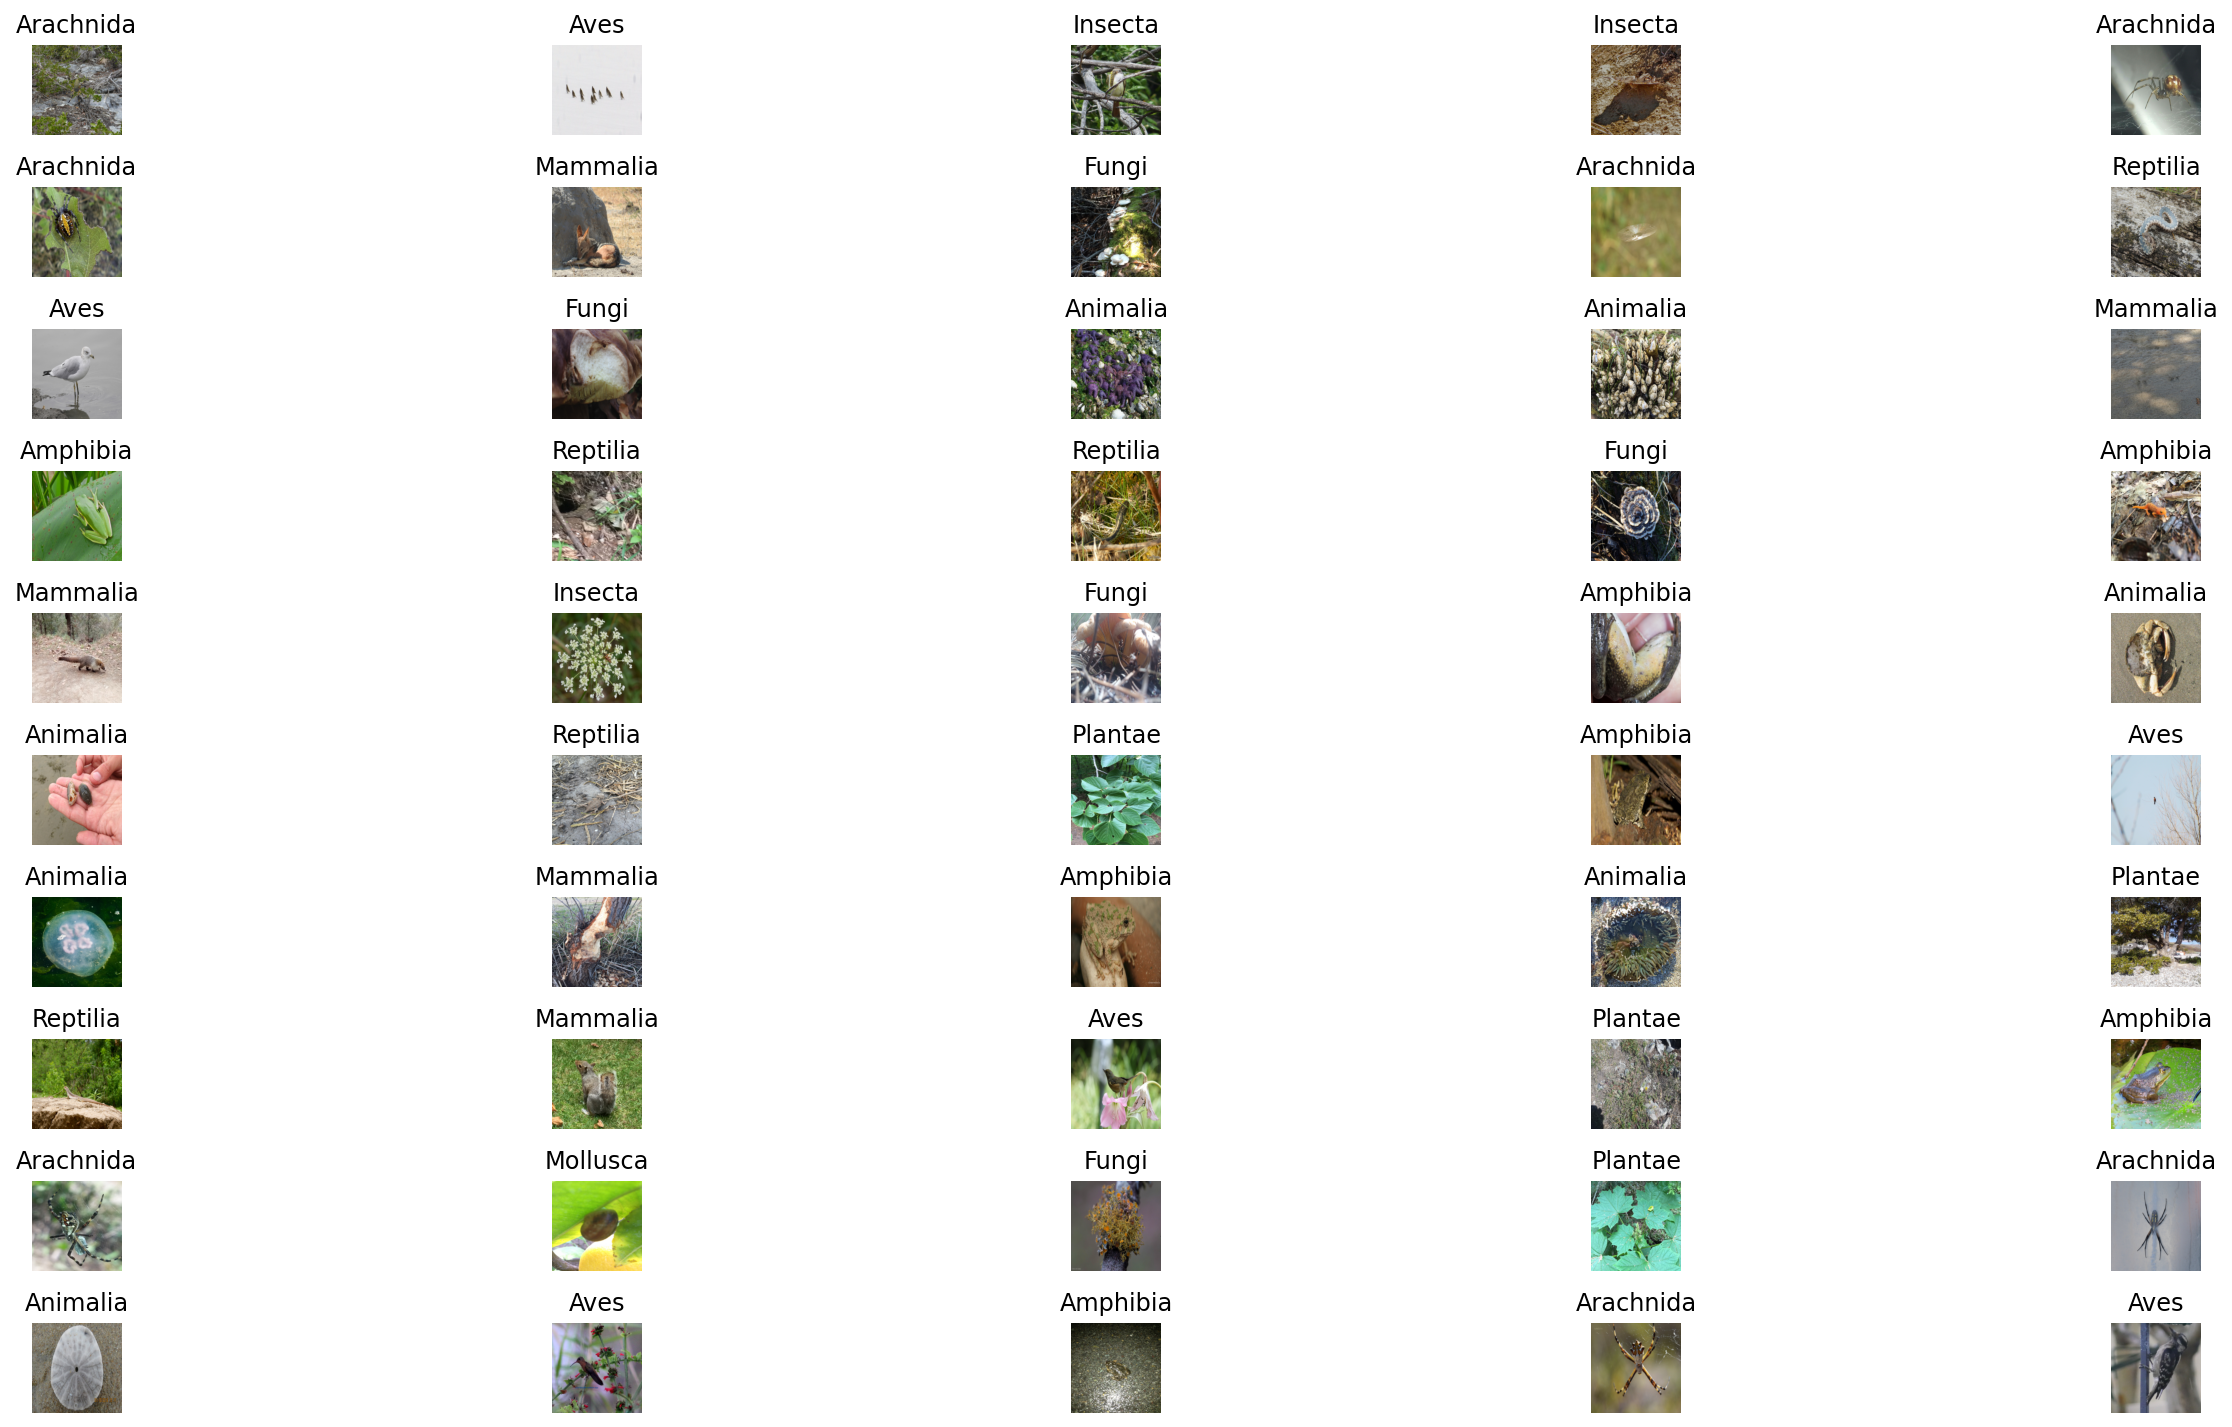

In [ ]:
#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=50, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = transforms.Resize(size=(params['image_size'],params['image_size']))
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 10))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,ac1='relu',ac2='relu',ac3='relu',ac4='relu',ac5='relu',ac6='relu',in_channels=3,no_filters_1=6,filter_size1=3,pool_size1=2,no_filters_2=6,filter_size2=3,pool_size2=2,no_filters_3=6,filter_size3=3,pool_size3=2,no_filters_4=6,filter_size4=3,pool_size4=2,no_filters_5=6,filter_size5=3,pool_size5=2,fc1_size=30,ol_size=10):
        super().__init__()
        self.activations = {
            'relu' : F.relu,
            'tanh' : F.tanh,
            'sigmoid':F.sigmoid,
            'leaky-relu':F.leaky_relu,
        }
        self.ac1 = ac1
        self.ac2 = ac2
        self.ac3 = ac3
        self.ac4 = ac4
        self.ac5 = ac5
        self.ac6 = ac6
        self.conv1 = nn.Conv2d(in_channels, no_filters_1, filter_size1) #input_size
        curr = self.conv1
        H,W = params['image_size'],params['image_size']
        H = self.getDim(H,curr.padding[0],curr.dilation[0],curr.kernel_size[0],curr.stride[0])
        W = self.getDim(W,curr.padding[1],curr.dilation[1],curr.kernel_size[1],curr.stride[1])
        self.pool1 = nn.MaxPool2d(pool_size1, 2)
        curr = self.pool1
        H = self.getDim(H,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        W = self.getDim(W,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        self.conv2 = nn.Conv2d(no_filters_1, no_filters_2, filter_size2) #input_size/2
        curr = self.conv2
        H = self.getDim(H,curr.padding[0],curr.dilation[0],curr.kernel_size[0],curr.stride[0])
        W = self.getDim(W,curr.padding[1],curr.dilation[1],curr.kernel_size[1],curr.stride[1])
        self.pool2 = nn.MaxPool2d(pool_size2,2)
        curr = self.pool2
        H = self.getDim(H,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        W = self.getDim(W,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        self.conv3 = nn.Conv2d(no_filters_2, no_filters_3, filter_size3) #input_size/2^2
        curr = self.conv3
        H = self.getDim(H,curr.padding[0],curr.dilation[0],curr.kernel_size[0],curr.stride[0])
        W = self.getDim(W,curr.padding[1],curr.dilation[1],curr.kernel_size[1],curr.stride[1])
        self.pool3 = nn.MaxPool2d(pool_size3,2)
        curr = self.pool3
        H = self.getDim(H,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        W = self.getDim(W,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        self.conv4 = nn.Conv2d(no_filters_3, no_filters_4, filter_size4) #input_size/2^3
        curr = self.conv4
        H = self.getDim(H,curr.padding[0],curr.dilation[0],curr.kernel_size[0],curr.stride[0])
        W = self.getDim(W,curr.padding[1],curr.dilation[1],curr.kernel_size[1],curr.stride[1])
        self.pool4 = nn.MaxPool2d(pool_size4,2)
        curr = self.pool4
        H = self.getDim(H,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        W = self.getDim(W,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        self.conv5 = nn.Conv2d(no_filters_4, no_filters_5, filter_size5) #input_size/2^4
        curr = self.conv5
        H = self.getDim(H,curr.padding[0],curr.dilation[0],curr.kernel_size[0],curr.stride[0])
        W = self.getDim(W,curr.padding[1],curr.dilation[1],curr.kernel_size[1],curr.stride[1])
        self.pool5 = nn.MaxPool2d(pool_size5,2)
        curr = self.pool5
        H = self.getDim(H,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        W = self.getDim(W,curr.padding,curr.dilation,curr.kernel_size,curr.stride)
        self.fc1 = nn.Linear(int(H*W*no_filters_5), fc1_size)
        self.ol = nn.Linear(fc1_size, ol_size)
        
    def getDim(self,n,padding,dilation,kernel_size,stride):
        return np.floor((n + 2*padding - dilation*(kernel_size - 1)-1)/stride + 1)

    def forward(self, x):
        x = self.pool1(self.activations[self.ac1](self.conv1(x)))
        x = self.pool2(self.activations[self.ac2](self.conv2(x)))
        x = self.pool3(self.activations[self.ac3](self.conv3(x)))
        x = self.pool4(self.activations[self.ac4](self.conv4(x)))
        x = self.pool5(self.activations[self.ac5](self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = self.activations[self.ac6](self.fc1(x))
        x = self.ol(x)
        return x

    


cnet = ConvNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# for i,data in enumerate(trainloader, 0):
#   inputs, labels = data
#   cnet(inputs)
#   break
# Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)
cnet.to(device)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=216, out_features=30, bias=True)
  (ol): Linear(in_features=30, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnet.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(cnet.parameters(),lr=0.001)


In [ ]:
for epoch in range(params['epochs']):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % params['batch_size'] == params['batch_size']-1:    # print after every  mini-batch
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.5f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,    64] loss: 14.76883
[1,   128] loss: 14.76556
[2,    64] loss: 14.75658
[2,   128] loss: 14.76331
Finished Training


In [ ]:
model_paths = os.path.curdir
torch.save(cnet.state_dict(),model_paths+ "/model1.pth")

In [ ]:
net = ConvNet()
net.load_state_dict(torch.load(model_paths+"/model1.pth"))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


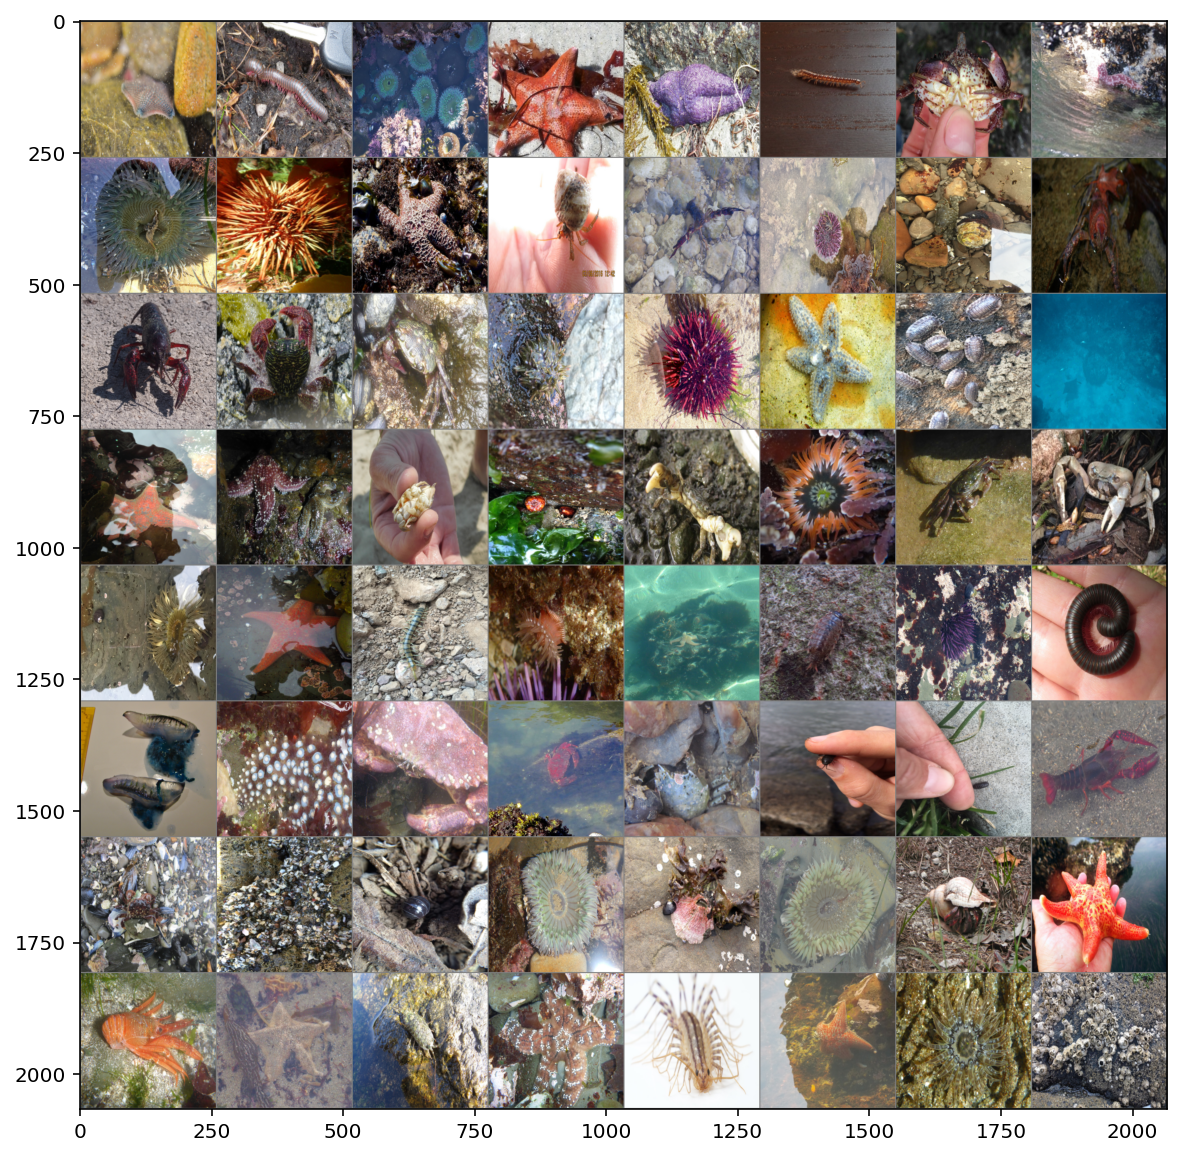

GroundTruth:  Animalia Animalia Animalia Animalia


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = net(images)
outputs

tensor([[ 0.1023,  0.1380,  0.0141, -0.0228,  0.1226, -0.0673, -0.0698,  0.0137,
          0.0983,  0.0757],
        [ 0.1054,  0.1398,  0.0154, -0.0239,  0.1219, -0.0679, -0.0650,  0.0138,
          0.1003,  0.0758],
        [ 0.1045,  0.1394,  0.0150, -0.0233,  0.1223, -0.0684, -0.0662,  0.0136,
          0.0998,  0.0761],
        [ 0.1043,  0.1392,  0.0150, -0.0229,  0.1217, -0.0677, -0.0662,  0.0138,
          0.0991,  0.0744],
        [ 0.1038,  0.1391,  0.0143, -0.0232,  0.1223, -0.0679, -0.0666,  0.0147,
          0.0997,  0.0753],
        [ 0.1044,  0.1390,  0.0150, -0.0233,  0.1219, -0.0676, -0.0666,  0.0135,
          0.0997,  0.0751],
        [ 0.1040,  0.1403,  0.0144, -0.0229,  0.1218, -0.0675, -0.0661,  0.0125,
          0.0990,  0.0759],
        [ 0.1042,  0.1400,  0.0148, -0.0235,  0.1225, -0.0680, -0.0675,  0.0124,
          0.0981,  0.0766],
        [ 0.1054,  0.1397,  0.0150, -0.0237,  0.1218, -0.0679, -0.0654,  0.0136,
          0.0998,  0.0752],
        [ 0.1049,  

In [ ]:
_,predicted = torch.max(outputs,1)
predicted

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])